<a href="https://colab.research.google.com/github/juhee3199/Machine-learning_advanced-study/blob/juhee3199-basic_code/classification/Ensemble-%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98_%EC%BA%90%EA%B8%80%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류 실습 - 캐글 산탄데르 고객 만족 예측

- 데이터셋: 1=불만족 고객, 0=만족 고객
- XGB, LGBM을 활용해 예측



In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 12.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=8b86cca4024b60a1a0a6c43fae4fb8a4d37c349fe914689f2ec8e30260caf540
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
# kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle -v

Kaggle API 1.5.6


In [ ]:
!kaggle competitions download -c santander-customer-satisfaction

!unzip santander-customer-satisfaction.zip

 61% 5.00M/8.25M [00:00<00:00, 20.8MB/s]
100% 8.25M/8.25M [00:00<00:00, 32.9MB/s]
Archive:  santander-customer-satisfaction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 데이터 로드
cust_df = pd.read_csv('train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
# 타겟 비율 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율: {0:.2f}'.format(unsatisfied_cnt/total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율: 0.04


In [ ]:
cust_df.describe()

# NaN값을 -9999로 변경해놓은 상태

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

x_features=cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(x_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('train shape',x_train.shape)
print('test shape', y_train.shape)

print('train 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('test 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

train shape (60816, 369)
test shape (60816,)
train 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
test 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


- XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators=100, random_state=156) #수행속도 향상을 위해 n_estimator=100으로 
xgb_clf.fit(x_train,y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(n_estimators=100, random_state=156) 

params ={'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

grid_cv = GridSearchCV(xgb_clf, param_grid = params, cv=3)
grid_cv.fit(x_train,y_train, early_stopping_rounds=30, 
            eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

print('GridCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

xgb_roc_score = roc_auc_score(y_test, grid_cv.predict_proba(x_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.808554	validation_1-auc:0.808312
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.813657	validation_1-auc:0.813928
[2]	validation_0-auc:0.803792	validation_1-auc:0.811241
[3]	validation_0-auc:0.818094	validation_1-auc:0.819595
[4]	validation_0-auc:0.822706	validation_1-auc:0.824675
[5]	validation_0-auc:0.811541	validation_1-auc:0.815635
[6]	validation_0-auc:0.824344	validation_1-auc:0.823535
[7]	validation_0-auc:0.829825	validation_1-auc:0.827602
[8]	validation_0-auc:0.834345	validation_1-auc:0.831343
[9]	validation_0-auc:0.835108	validation_1-auc:0.831486
[10]	validation_0-auc:0.833181	validation_1-auc:0.830521
[11]	validation_0-auc:0.831342	validation_1-auc:0.829627
[12]	validation_0-auc:0.826319	validation_1-auc:0.825715
[13]	validation_0-auc:0.8319	validation_1-auc:0.829615
[14]	validation_0-auc:0.834867	validation_1-auc:0.831223


In [ ]:
# n_estimatr 1000으로 증가, lr 감소, reg_alpha 추가

xgb_clf = XGBClassifier(n_estimators=100, random_state=156,
                        learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03) 
xgb_clf.fit(x_train,y_train, early_stopping_rounds=200, 
            eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

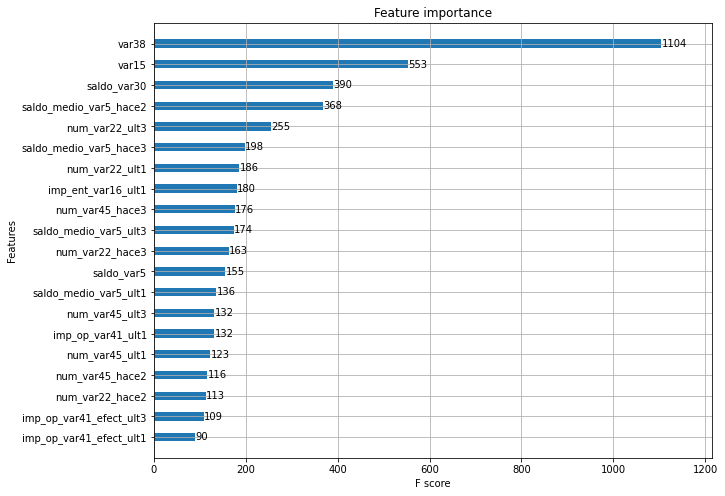

In [ ]:
# 피처 중요도 확인
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

- LGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=200)
evals = [(x_test, y_test)]
lgbm_clf.fit(x_train,y_train, early_stopping_rounds=100, eval_metric ='auc', eval_set = evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

In [ ]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(x_train, y_train), (x_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(x_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(x_test, y_test)]
lgbm_clf.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss